# Curve optimization with the curves library

The [curve library](https://github.com/loco-3d/curves) is a header-only C++ library (also binded in python) that allows you
to create curves, in arbitrary dimensions (2, 3, n). 
Originally, the library focused on spline curves, but it has now been extended to generic polynomials, cubic hermite splines, Bezier curves and more. 
A nice upcoming extension is the ability to design curves in the Special Euclidian group SE3.

However in this tutorial we are going to focus on a rather unique trait of the library, which is the ability to work with variable control points. Rather than being given a constant value, the control points can be expressed as the linear combination of one or several variables. The main advantage of this representation is that variable curves
can be automatically derivated or integrated without any effort. 

The other interest of variable curves is the ability to easily formulate optimization problems, which will be the focus of this tutorial. We will use the python bindings of the curve library to go through the steps of formulating and solving an optimization problem.

## The problem: trajectory fitting

We start with a simple, unconstrained problem. 

Let us first consider a 3D curve:

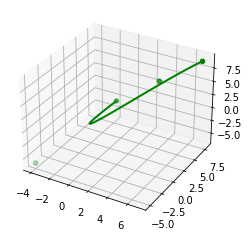

In [8]:
# importing classical numpy objects
from numpy import zeros, array, identity, dot
from numpy.linalg import norm
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

#use array representation for binding eigen objects to python
import eigenpy
eigenpy.switchToNumpyArray()

#importing the bezier curve class
from ndcurves import (bezier)

#importing tools to plot bezier curves
from ndcurves.plot import (plotBezier)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

#We describe a degree 3 curve as a Bezier curve with 4 control points
waypoints = array([[1., 2., 3.], [-4., -5., -6.], [4., 5., 6.], [7., 8., 9.]]).transpose()
ref = bezier(waypoints)

#plotting the curve with its control points
plotBezier(ref,showControlPoints = True, color="g")

We now assume that we only have partial information about this curve, and that we want to reconstruct it.

We will first generate a discretization of the curve to represent a temporal sampling:

In [9]:
numSamples = 10; fNumSamples = float(numSamples)
ptsTime = [ (ref(float(t) / fNumSamples), float(t) / fNumSamples) for t in range(numSamples+1)]
for el in ptsTime:
    print (el)

(array([1.0, 2.0, 3.0]), 0.0)
(array([-0.1, 0.4, 0.9]), 0.1)
(array([-0.6, -0.4, -0.1]), 0.2)
(array([-0.5, -0.4, -0.2]), 0.3)
(array([0.1, 0.2, 0.4]), 0.4)
(array([1.0, 1.2, 1.5]), 0.5)
(array([2.2, 2.6, 3.0]), 0.6)
(array([3.4, 4.1, 4.7]), 0.7)
(array([4.7, 5.6, 6.4]), 0.8)
(array([6.0, 6.9, 7.9]), 0.9)
(array([7.0, 8.0, 9.0]), 1.0)


Each entry of ptsTime is a couple (position, time) that describes our input data.

### Sanity check
Let's first solve a trivial problem, to see if we can reconstruct the curve with a polynomial
of same degree.
To achieve this we will use the problemDefinition class, which will automatically generate the variable expression of the curve

In [10]:
from ndcurves.optimization import (problem_definition, setup_control_points)

#dimension of our problem (here 3 as our curve is 3D)
dim = 3
refDegree = 3
pD = problem_definition(dim)
pD.degree = refDegree #we want to fit a curve of the same degree as the reference curve for the sanity check

#generates the variable bezier curve with the parameters of problemDefinition
problem = setup_control_points(pD)
#for now we only care about the curve itself
variableBezier = problem.bezier()

The evaluation of a variable Bezier returns a matrix B and a vector c, such 
that B x + c , with x a vector variable, defines the value of the curve

In [11]:
linearVariable = variableBezier(0.)
print ("B: \n", linearVariable.B())
print ("c:\n",linearVariable.c())
print ("Shape of B: ", linearVariable.B().shape)

B: 
 [[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]
c:
 [0.0 0.0 0.0]
Shape of B:  (3, 12)


B has 3 rows and 12 columns. Because the fitting curve is of degree 3, it has 4 control points of dimension 3, which gives a variable of size 12. The row number also matches the dimension of the problem.
Then A is zero everywhere, expect for the first 3 columns that contain the identity. This is expected as the start of a Bezier curve is equal to the first control point.

If we evaluate variableBezier at t = 0.2 for instance, we get a more complex expression:

In [12]:
print ("B: \n", variableBezier(0.2).B())

B: 
 [[0.5 0.0 0.0 0.4 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.5 0.0 0.0 0.4 0.0 0.0 0.1 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.5 0.0 0.0 0.4 0.0 0.0 0.1 0.0 0.0 0.0]]


With variableBezier, we can easily define a least square problem to reconstruct the original curve.
We just have to formulate a cost function that, for each sample in ptsTime minimizes the distance between the evaluation of variableBezier and the sampled point. We define it as follows:

In [13]:
#least square form of ||Ax-b||**2 
def to_least_square(A, b):
    return dot(A.T, A), - dot(A.T, b)

def genCost(variableBezier, ptsTime):
    #first evaluate variableBezier for each time sampled
    allsEvals = [(variableBezier(time), pt) for (pt,time) in ptsTime]
    #then compute the least square form of the cost for each points
    allLeastSquares = [to_least_square(el.B(), -el.c() + pt) for (el, pt) in  allsEvals]
    #and finally sum the costs
    Ab = [sum(x) for x in zip(*allLeastSquares)]
    return Ab[0], Ab[1]
A, b = genCost(variableBezier, ptsTime)

Here we use quadprog to solve the least square. Because there are no constraint this might seem overkill, however we will introduce them soon enough.

In [15]:
import quadprog
from numpy import array, hstack, vstack

def quadprog_solve_qp(P, q, G=None, h=None, C=None, d=None, verbose=False):
    """
    min (1/2)x' P x + q' x
    subject to  G x <= h
    subject to  C x  = d
    """
    qp_G = .5 * (P + P.T)  # make sure P is symmetric
    qp_a = -q
    qp_C = None
    qp_b = None
    meq = 0
    if C is not None:
        if G is not None:
            qp_C = -vstack([C, G]).T
            qp_b = -hstack([d, h])
        else:
            qp_C = -C.transpose()
            qp_b = -d
        meq = C.shape[0]
    elif G is not None:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    if verbose:
        return res
    # print('qp status ', res)
    return res[0]

res = quadprog_solve_qp(A, b)

Let's check whether our optimization worked !
We can transform the variable Bezier as a regular Bezier curve as follows, and plot the result to verify that the curves match.

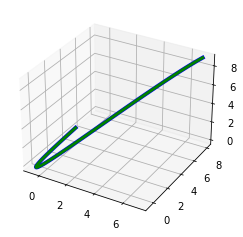

In [16]:
def evalAndPlot(variableBezier, res):
    fitBezier = variableBezier.evaluate(res.reshape((-1,1)) ) 
    #plot reference curve in blue, fitted curve in green
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")  
    plotBezier(ref, ax = ax, linewidth=4.) #thicker line to visualize overlap
    plotBezier(fitBezier, ax = ax, color ="g", linewidth=3.) 
    plt.show()
    return fitBezier
    
fitBezier = evalAndPlot(variableBezier, res)

### initial and terminal constraints
Let's try to fit the reference curve with a curve of lesser degree

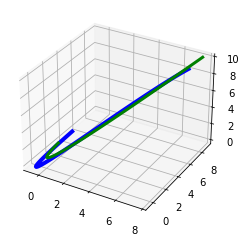

In [17]:
pD.degree = refDegree - 1


problem = setup_control_points(pD)
variableBezier = problem.bezier()

A, b = genCost(variableBezier, ptsTime)
res = quadprog_solve_qp(A, b)
fitBezier = evalAndPlot(variableBezier, res)
    

We can see that the initial and goal positions are not reached. 
A constraint_flag can be used to impose constraints on the initial/goal positions
and derivatives if required.
Let's rewrite simplefit to handle such case

In [21]:
from ndcurves.optimization import constraint_flag

pD.flag = constraint_flag.INIT_POS | constraint_flag.END_POS
#set initial position
pD.init_pos = array([ptsTime[ 0][0]]).T
#set end position
pD.end_pos   = array([ptsTime[-1][0]]).T
problem = setup_control_points(pD)
variableBezier = problem.bezier()

By imposing the initial and final position, we effectively reduce the number of variables by 6:

In [22]:
print ("Shape of B: ", variableBezier(0).B().shape)

Shape of B:  (3, 3)


The least squares problem then has the following solution

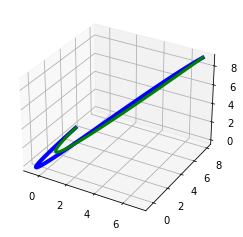

In [23]:

prob = setup_control_points(pD)
variableBezier = prob.bezier()
A, b = genCost(variableBezier, ptsTime)
res = quadprog_solve_qp(A, b)
_ = evalAndPlot(variableBezier, res)
    

To impose constraints on the derivatives, we can activate the appropriate constraint flags as follows.
Note that derivatives constraints on velocities will only be considered if the constraints on position are also active.
For instance to impose a 0 velocity and acceleration at the initial and goal states we can proceed as follows:

In [24]:
#values are 0 by default, so if the constraint is zero this can be skipped
pD.init_vel = array([[0., 0., 0.]]).T
pD.init_acc = array([[0., 0., 0.]]).T
pD.end_vel = array([[0., 0., 0.]]).T
pD.end_acc = array([[0., 0., 0.]]).T
pD.flag = constraint_flag.END_POS | constraint_flag.INIT_POS | constraint_flag.INIT_VEL  | constraint_flag.END_VEL  | constraint_flag.INIT_ACC  | constraint_flag.END_ACC

However, the definition of the variable problem will result in an error. Do you know why ?

In [25]:
try:
    prob = setup_control_points(pD)
except RuntimeError as e:
    print (e)

In setup_control_points; too many constraints for the considered degree


Indeed, there are not enough variables left in the problem to satisfy the constraints. We need to increase the degree of the curve:

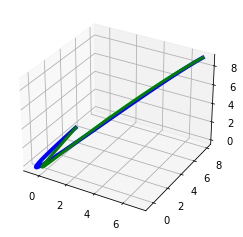

In [26]:
pD.degree = refDegree + 4
prob = setup_control_points(pD)
variableBezier = prob.bezier()
A, b = genCost(variableBezier, ptsTime)
res = quadprog_solve_qp(A, b)
fitBezier = evalAndPlot(variableBezier, res)

We can check that the derivatives of the curve are 0 at start and end

In [27]:
print ("initial velocity", fitBezier.derivate(fitBezier.min(),1))
print ("initial acceleration", fitBezier.derivate(fitBezier.min(),2))
print ("end velocity", fitBezier.derivate(fitBezier.max(),1))
print ("end acceleration", fitBezier.derivate(fitBezier.max(),2))

initial velocity [0.0 0.0 0.0]
initial acceleration [0.0 0.0 0.0]
end velocity [0.0 0.0 0.0]
end acceleration [0.0 0.0 0.0]


Of course, with such constraints the curve does not really look like the original one anymore.
Although it is not recommended, the library is robust enough to allow for adding an arbitrary number of control points.
Just for fun, let's add 60 more control points and check that the curve is matched better

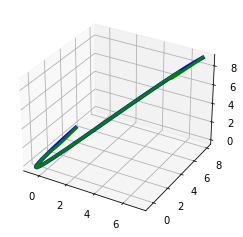

In [28]:
pD.degree = refDegree + 60
prob = setup_control_points(pD)
variableBezier = prob.bezier()
A, b = genCost(variableBezier, ptsTime)
#regularization matrix 
reg = identity(A.shape[1]) * 0.001
res = quadprog_solve_qp(A + reg, b)
fitBezier = evalAndPlot(variableBezier, res)

## Adding equality and inequality constraints

Suppose we want to add specific constraint.
For instance, we want that the velocity be exactly 0 at t = 0.8, additionally to the start and goal positions being satisfied. This can be done easily by obtaining the variable equation for the variable curve at that time.

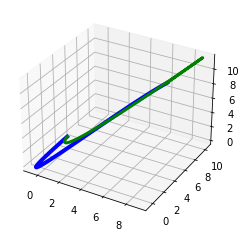

In [29]:
#set initial / terminal constraints
pD.flag = constraint_flag.END_POS | constraint_flag.INIT_POS
pD.degree = refDegree
prob = setup_control_points(pD)
variableBezier = prob.bezier()

#get value of the curve first order derivative at t = 0.8
t08Constraint = variableBezier.derivate(0.8,1)
target = zeros(3) 

A, b = genCost(variableBezier, ptsTime)
#solve optimization problem with quadprog

res = quadprog_solve_qp(A, b, C=t08Constraint.B(), d=target - t08Constraint.c())
fitBezier = evalAndPlot(variableBezier, res)

assert norm(fitBezier.derivate(0.8,1) - target) <= 0.001


Of course, inequality constraints can be added in a similar way

## Constraining sub-parts of the curve

Now suppose we want to constrain entirely parts of a curve. One common way to address this is to discretize the curve, and write as many constraints as discretization points.

Alternatively, this can be achieved continuously by splitting the Bezier curve continuously, and putting constraints on the control points of the relevant parts.

let's first explain how curve splitting works before writing a problem.

Here is the code that splits our reference curve into two distinct curves at a time t = 0.6

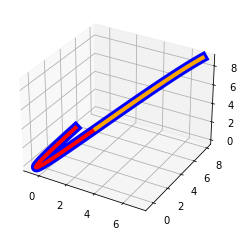

In [30]:
#returns a curve composed of the split curves, 2 in our case
piecewiseCurve = ref.split(array([[0.6]]).T)

#displaying the obtained curves

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  

#first, plotting the complete piecewiseCurve is equivalent
plotBezier(piecewiseCurve, ax = ax, linewidth=10., color = "b")
plotBezier(piecewiseCurve.curve_at_index(0), ax = ax, linewidth=4., color = "r")
plotBezier(piecewiseCurve.curve_at_index(1), ax = ax, linewidth=4., color = "orange")

The split is achieved by the De Casteljau algorithm. The continuity at the split location is infinite.
Of course, the split will also work for variable Bezier curves.
We can exploit the convexity of Bezier curves to continuously impose constraints on a given interval of the curve.
If the control points of the sub curve satisfy a set of linear constraints, then the entire sub-curve satisfies the constraint.

For instance, let us impose the z value to be negative between t = 0.4 and t= O.8

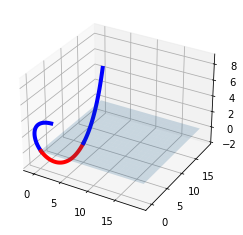

In [31]:
#first, split the variable curve
piecewiseCurve = variableBezier.split(array([[0.4, 0.8]]).T)

constrainedCurve = piecewiseCurve.curve_at_index(1)

#find the number of variables
problemSize = prob.numVariables * dim
#find the number of constraints, as many as waypoints
nConstraints = constrainedCurve.nbWaypoints

waypoints = constrainedCurve.waypoints()

ineqMatrix = zeros((nConstraints, problemSize))
ineqVector = zeros(nConstraints)


#finding the z equation of each control point
for i in range(nConstraints):
    wayPoint = constrainedCurve.waypointAtIndex(i)
    ineqMatrix[i,:] = wayPoint.B()[2,:]
    ineqVector[i] =  -wayPoint.c()[2]

    
res = quadprog_solve_qp(A, b, G=ineqMatrix, h = ineqVector)
fitBezier = variableBezier.evaluate(res.reshape((-1,1)) ) 



fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")  

#now plotting the obtained curve, in red the concerned part
piecewiseFit = fitBezier.split(array([[0.4, 0.8]]).T)
plotBezier(piecewiseFit.curve_at_index(0), ax = ax, linewidth=4., color = "b")
plotBezier(piecewiseFit.curve_at_index(1), ax = ax, linewidth=4., color = "r")
plotBezier(piecewiseFit.curve_at_index(2), ax = ax, linewidth=4., color = "b")

#plotting the plane z = 0
xx, yy = np.meshgrid(range(20), range(20))

# calculate corresponding z
z = (0 * xx - 0 * yy )

# plot the surface
ax.plot_surface(xx, yy, z, alpha=0.2)
plt.show()